# Imbalanced datasets
------------------------------------

This example shows how to handle imbalanced datasets using ATOM's branch system to evaluate differrent pipelines.

## Load the data

In [1]:
# Import packages
from atom import ATOMClassifier
from sklearn.datasets import make_classification

In [2]:
# Create a mock imbalanced dataset
X, y = make_classification(n_samples=1000, weights=(0.95,), random_state=1)

## Run the pipeline

In [3]:
# Initialize ATOM with the created dataset
atom = ATOMClassifier(X, y, test_size=0.2, verbose=2, random_state=1)

<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ====================== >>
Shape: (1000, 21)
Scaled: True
Outlier values: 91 (0.5%)
---------------------------------------
Train set size: 800
Test set size: 200
---------------------------------------
|    | dataset    | train      | test       |
|---:|:-----------|:-----------|:-----------|
|  0 | 945 (17.2) | 754 (16.4) | 191 (21.2) |
|  1 | 55 (1.0)   | 46 (1.0)   | 9 (1.0)    |



In [4]:
# Have a look at the data, note that atom automatically
# names the columns if the input is not a dataframe
atom.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 12,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Target
0,-1.589560,0.104910,0.125240,0.306000,-0.119472,-0.412497,0.195832,-1.478023,-1.563505,0.666030,...,0.013924,-1.377594,-0.087810,1.008428,-0.385521,-2.094381,0.482790,-1.408973,0.076441,0
1,0.476680,-0.911868,-1.658660,-0.774640,0.486952,-0.066127,-0.989610,-0.770401,0.341549,-0.465186,...,-0.264093,-0.479565,1.299482,-0.378359,1.174563,0.382860,-1.213936,-0.035720,-0.453976,0
2,-0.274674,0.668523,0.534805,-1.205574,-0.367468,-0.735314,-0.258589,0.204160,-0.491376,-0.788470,...,0.040235,-1.883139,-0.393081,0.034290,0.067912,1.376503,-2.512454,-0.947204,0.752307,0
3,-1.322943,0.373902,0.301676,0.340079,1.505533,-0.684503,2.053475,0.515006,-1.130264,-0.071174,...,-0.497840,-1.034886,-1.101358,0.848783,-0.610793,2.673071,0.265086,-0.817729,-0.464064,0
4,-0.437990,0.076926,-1.396307,0.616182,1.006997,-0.102365,-0.713030,1.318968,-1.026331,-0.914775,...,1.122136,0.315690,-0.504619,0.337018,0.944618,-0.122163,-0.954076,1.465656,1.421709,1


In [5]:
# Let's start reducing the number of features
atom.feature_selection("RFE", solver="LR", n_features=12)

Fitting FeatureSelector...
Performing feature selection ...
 --> The RFE selected 12 features from the dataset.
   >>> Dropping feature Feature 5 (rank 2).
   >>> Dropping feature Feature 6 (rank 7).
   >>> Dropping feature Feature 8 (rank 4).
   >>> Dropping feature Feature 9 (rank 5).
   >>> Dropping feature Feature 16 (rank 8).
   >>> Dropping feature Feature 17 (rank 9).
   >>> Dropping feature Feature 18 (rank 6).
   >>> Dropping feature Feature 20 (rank 3).


In [6]:
# Now, we fit a SVM model directly on the imbalanced data
atom.run("kSVM", metric="ba", bagging=5)


Training ===================================== >>
Models: kSVM
Metric: balanced_accuracy


Results for Kernel-SVM:         
Fit ---------------------------------------------
Train evaluation --> balanced_accuracy: 0.5652
Test evaluation --> balanced_accuracy: 0.5556
Time elapsed: 0.040s
Bagging -----------------------------------------
Evaluation --> balanced_accuracy: 0.5757 ± 0.028
Time elapsed: 0.098s
-------------------------------------------------
Total time: 0.138s


Final results ========================= >>
Duration: 0.138s
------------------------------------------
Kernel-SVM --> balanced_accuracy: 0.5757 ± 0.028


## Class weights

In [7]:
# Train another SVM using class weight
# Add custom parameters through est_params
# Note the tag after the model's acronym to differentiate this model from the first
atom.run("kSVM_cw", est_params={"class_weight": atom.get_class_weight()}, bagging=5)


Training ===================================== >>
Models: kSVM_cw
Metric: balanced_accuracy


Results for Kernel-SVM:         
Fit ---------------------------------------------
Train evaluation --> balanced_accuracy: 0.9728
Test evaluation --> balanced_accuracy: 0.6725
Time elapsed: 0.051s
Bagging -----------------------------------------
Evaluation --> balanced_accuracy: 0.6634 ± 0.0263
Time elapsed: 0.105s
-------------------------------------------------
Total time: 0.157s


Final results ========================= >>
Duration: 0.157s
------------------------------------------
Kernel-SVM --> balanced_accuracy: 0.6634 ± 0.0263 ~


In [8]:
atom.kSVM_cw.estimator  # Check that the estimator indeed uses class weight

SVC(class_weight={0: 1.061, 1: 17.391}, random_state=1)

In [9]:
# The transformer and the models have been added to the branch
atom.branch

Branch: master
 --> Pipeline: 
   >>> FeatureSelector
     --> strategy: RFE
     --> solver: LogisticRegression(n_jobs=1, random_state=1)
     --> n_features: 12
     --> max_frac_repeated: 1.0
     --> max_correlation: 1.0
     --> kwargs: {}
 --> Models: kSVM, kSVM_cw

## Oversampling

In [10]:
# Create a new branch for oversampling
atom.branch = "oversample"

New branch oversample successfully created!


In [11]:
atom.branch  # The branch adopts all transformers from the parent branch

Branch: oversample
 --> Pipeline: 
   >>> FeatureSelector
     --> strategy: RFE
     --> solver: LogisticRegression(n_jobs=1, random_state=1)
     --> n_features: 12
     --> max_frac_repeated: 1.0
     --> max_correlation: 1.0
     --> kwargs: {}
 --> Models: None

In [12]:
# Perform oversampling of the minority class
atom.balance(strategy="smote")

Oversampling with SMOTE...
 --> Adding 708 samples to class: 1.


In [13]:
atom.classes  # Check the balanced training set!

,dataset,train,test
0,945,754,191
1,763,754,9


In [14]:
# Train another SVM model on this branch
atom.run("kSVM_os", bagging=5)


Training ===================================== >>
Models: kSVM_os
Metric: balanced_accuracy


Results for Kernel-SVM:         
Fit ---------------------------------------------
Train evaluation --> balanced_accuracy: 0.9721
Test evaluation --> balanced_accuracy: 0.6803
Time elapsed: 0.093s
Bagging -----------------------------------------
Evaluation --> balanced_accuracy: 0.6741 ± 0.0027
Time elapsed: 0.172s
-------------------------------------------------
Total time: 0.266s


Final results ========================= >>
Duration: 0.266s
------------------------------------------
Kernel-SVM --> balanced_accuracy: 0.6741 ± 0.0027 ~


## Undersampling

In [15]:
# Create the undersampling branch
# Create from master to not adopt the SMOTE transformer!
atom.branch = "undersample_from_master"

New branch undersample successfully created!


In [16]:
atom.classes  # In this branch, the data is still imbalanced

,dataset,train,test
0,945,754,191
1,55,46,9


In [17]:
# Perform undersampling of the majority class
atom.balance(strategy="NearMiss")

Undersampling with NearMiss...
 --> Removing 708 samples from class: 0.


In [18]:
atom.run("kSVM_us", bagging=5)


Training ===================================== >>
Models: kSVM_us
Metric: balanced_accuracy


Results for Kernel-SVM:         
Fit ---------------------------------------------
Train evaluation --> balanced_accuracy: 0.837
Test evaluation --> balanced_accuracy: 0.6303
Time elapsed: 0.017s
Bagging -----------------------------------------
Evaluation --> balanced_accuracy: 0.6009 ± 0.0584
Time elapsed: 0.048s
-------------------------------------------------
Total time: 0.065s


Final results ========================= >>
Duration: 0.065s
------------------------------------------
Kernel-SVM --> balanced_accuracy: 0.6009 ± 0.0584 ~


## Analyze results

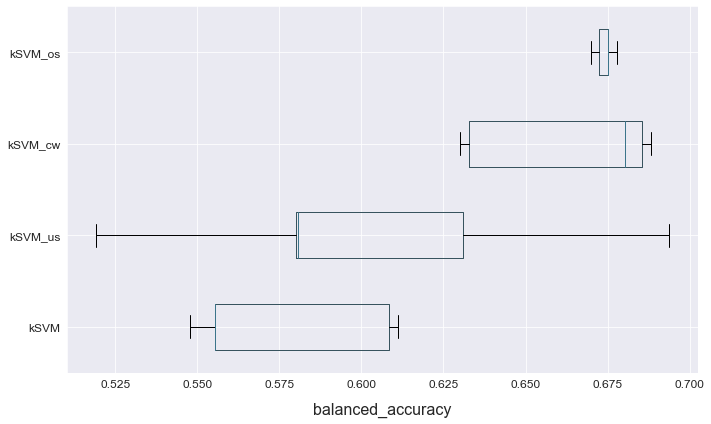

In [19]:
# Comparing the performances of all the SVM models can now easily
# be done through atom
atom.plot_results()

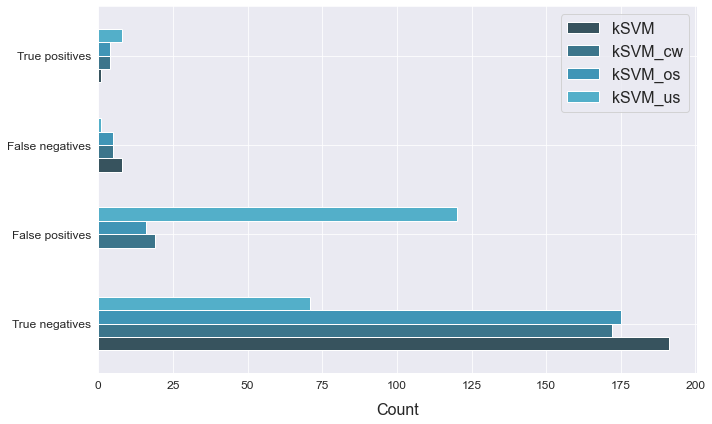

In [20]:
atom.plot_confusion_matrix()